In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import psycopg2
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import src.stat_helpers as stat_helpers
import src.wrangle_helpers as wrangle_helpers
import src.stats_maker as stats_maker

In [4]:
df_2019, groomed_df = wrangle_helpers.load_and_wrangle_data('../../data/housing2019.csv')

In [6]:
groomed_df['PowerLines'].value_counts()

0    29318
1      303
Name: PowerLines, dtype: int64

''

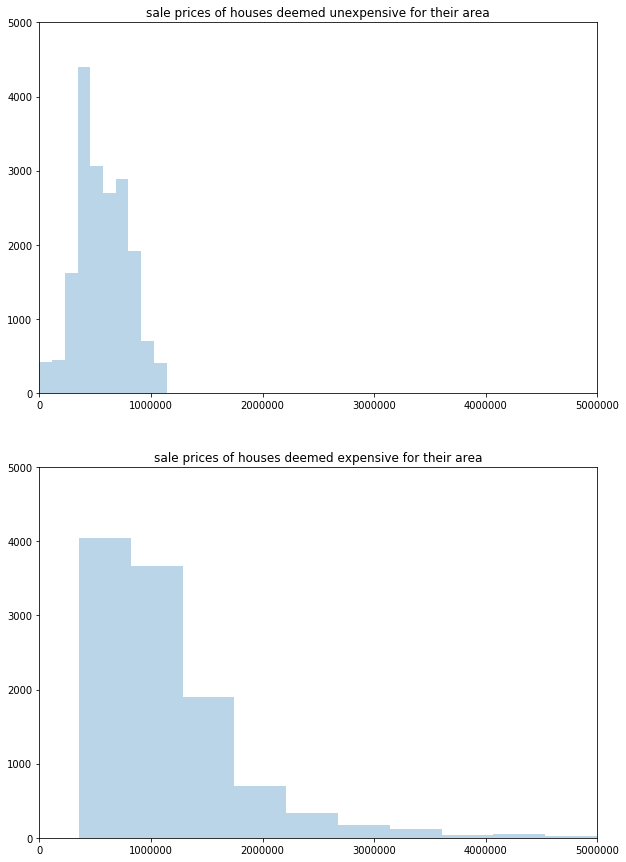

In [7]:
township_mean_sale_prices = {}
for town in df_2019['Township'].value_counts().index:
    township_mean_sale_prices[town] = df_2019[df_2019['Township'] == town]['SalePrice'].mean()

groomed_df['TownshipMeanSalePrice'] = groomed_df['Township'].map(township_mean_sale_prices)
groomed_df['TownshipMeanSalePrice'] = groomed_df['TownshipMeanSalePrice'].astype(int)
groomed_df['ExpensiveForArea?'] = (groomed_df['SalePrice'] >= groomed_df['TownshipMeanSalePrice']).astype(int)
groomed_df['ExpensiveForArea?']
fig, axs = plt.subplots(2, figsize=(10,15))
axs[0].set_ylim(0,5000)
axs[0].set_xlim(0,5000000)
axs[0].set_title('sale prices of houses deemed unexpensive for their area')

axs[0].hist(groomed_df[groomed_df['ExpensiveForArea?']==0]['SalePrice'],  alpha=0.3)

axs[1].set_ylim(0,5000)
axs[1].set_xlim(0,5000000)
axs[1].set_title('sale prices of houses deemed expensive for their area')
axs[1].hist(groomed_df[groomed_df['ExpensiveForArea?']==1]['SalePrice'],  alpha=0.3)
;

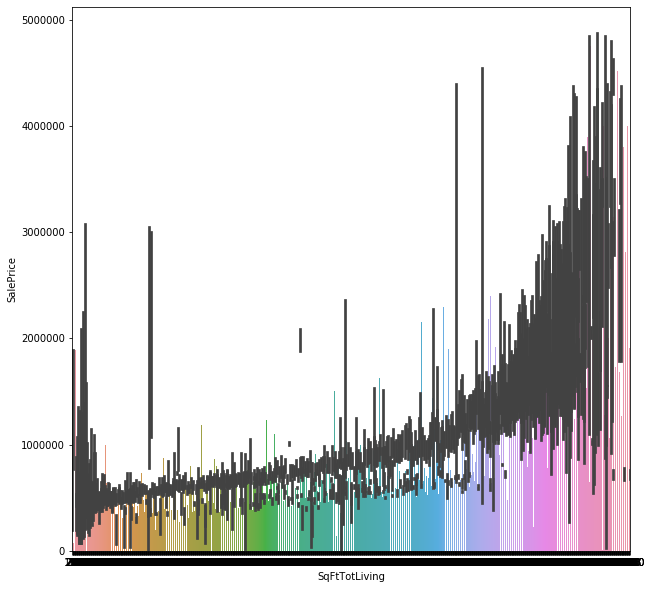

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.barplot(df_2019['SqFtTotLiving'], df_2019['SalePrice'])
# plt.savefig('SalePrice_by_SqFt_bar.png')

### Base Model

In [22]:
fsm = ols(formula='SalePrice ~ SqFtTotLiving', data=groomed_df).fit()
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                 1.547e+04
Date:                Fri, 06 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:09:24   Log-Likelihood:            -4.2558e+05
No. Observations:               29621   AIC:                         8.512e+05
Df Residuals:                   29619   BIC:                         8.512e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       1.24e+05   5818.374     21.317      0.000    1.13e+05    1.35e+05
SqFtTotLiving   303.8229      2.443    124.375      0.000     299.035     308.611
==============================================================================
Omnibus:                    15543.448   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           229982.402
Skew:                           2.184   Prob(JB):                         0.00
Kurtosis:                      15.933   Cond. No.                     5.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

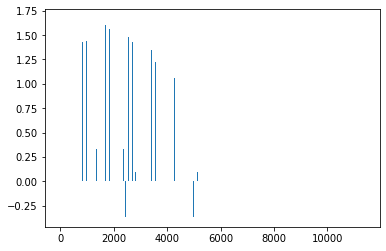

In [51]:
fig, ax = plt.subplots()
ax = plt.bar(groomed_df['SqFtTotLiving'].value_counts().index,np.log(np.log(groomed_df['SqFtTotLiving'].value_counts().values)))

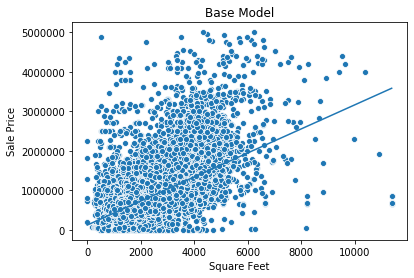

In [60]:
fig, ax = plt.subplots()
ax = sns.scatterplot(groomed_df['SqFtTotLiving'],  groomed_df['SalePrice'])
ax = sns.lineplot(groomed_df['SqFtTotLiving'], (303.82*groomed_df['SqFtTotLiving'] + 124030), alpha=1)
ax.set(xlabel='Square Feet', ylabel='Sale Price', title='Base Model')
plt.savefig('base_model_best_fit.png')

### Current Most Predictive Model and its Features' Colinearity

In [37]:
# groomed_df['SqFtTotLiving'] = np.log(groomed_df['SqFtTotLiving'])
columns = ['BldgGrade', 'TidelandShoreland', 'SqFtOpenPorch', 'SqFtDeck', 'Area', 'ViewScore','YrRenovated']
best_model = {'ols': stats_maker.get_model(groomed_df, columns).summary(),
              'vif': stats_maker.get_vif(groomed_df, columns)}
best_model['ols']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     3258.
Date:                Fri, 06 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:37:27   Log-Likelihood:            -4.2335e+05
No. Observations:               29621   AIC:                         8.467e+05
Df Residuals:                   29613   BIC:                         8.468e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -9.965e+05   1.61e+04    -61.859      0.000   -1.03e+06   -9.65e+05
BldgGrade          2.277e+05   2099.565    108.471      0.000    2.24e+05    2.32e+05
TidelandShoreland  3.875e+05   2.83e+04     13.680      0.000    3.32e+05    4.43e+05
SqFtOpenPorch       438.7000     16.503     26.583      0.000     406.353     471.047
SqFtDeck            100.7689     11.222      8.979      0.000      78.772     122.765
Area              -1053.7044     84.901    -12.411      0.000   -1220.114    -887.295
ViewScore          1.949e+05   4641.970     41.995      0.000    1.86e+05    2.04e+05
YrRenovated         109.7593      5.509     19.924      0.000      98.961     120.557
==============================================================================
Omnibus:                    16269.937   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           283186.578
Skew:                           2.267   Prob(JB):                         0.00
Kurtosis:                      17.453   Cond. No.                     5.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Exploratory Models

In [31]:
columns = ['SalePrice', 'BldgGrade']
stats_maker.get_vif(groomed_df, columns)

,VIF,feature
0,4.216489,SalePrice
1,4.216489,BldgGrade


In [32]:
columns = ['SalePrice', 'BldgGrade']
stats_maker.get_model(groomed_df, columns).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.607e+35
Date:                Fri, 06 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:33:00   Log-Likelihood:             6.3375e+05
No. Observations:               29621   AIC:                        -1.267e+06
Df Residuals:                   29618   BIC:                        -1.267e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.074e-10   5.21e-12    -39.836      0.000   -2.18e-10   -1.97e-10
SalePrice      1.0000   1.73e-18    5.8e+17      0.000       1.000       1.000
BldgGrade    1.41e-11    7.6e-13     18.544      0.000    1.26e-11    1.56e-11
==============================================================================
Omnibus:                     1782.067   Durbin-Watson:                   0.345
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3618.820
Skew:                          -0.423   Prob(JB):                         0.00
Kurtosis:                       4.489   Cond. No.                     6.86e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.86e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
# this model is still only using one feature represent change in sale price
# and is already improving the accuracy of our prediction
fsm = ols(formula='SalePrice ~ BldgGrade', data=groomed_df).fit().summary()
fsm

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                 1.636e+04
Date:                Fri, 06 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:34:43   Log-Likelihood:            -4.2529e+05
No. Observations:               29621   AIC:                         8.506e+05
Df Residuals:                   29619   BIC:                         8.506e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -1.24e+06    1.6e+04    -77.586      0.000   -1.27e+06   -1.21e+06
BldgGrade   2.628e+05   2054.490    127.924      0.000    2.59e+05    2.67e+05
==============================================================================
Omnibus:                    17668.502   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           260512.534
Skew:                           2.609   Prob(JB):                         0.00
Kurtosis:                      16.559   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
columns = ['SqFtTotLiving', 'TidelandShoreland', 'SqFtOpenPorch', 'SqFtDeck', 'Area', 'LakeSammamish', 'LakeWashington', 'SeattleSkyline', 'MtRainier', 'Olympics', 'Cascades',
                                'Territorial', 'SmallLakeRiverCreek',
                                'OtherView', 'YrRenovated']
# stats_maker.get_vif(groomed_df, columns)
stats_maker.get_model(groomed_df, columns).summary()
# stats_maker.get_vif(groomed_df, columns)



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     1438.
Date:                Fri, 06 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:41:44   Log-Likelihood:            -4.2370e+05
No. Observations:               29621   AIC:                         8.474e+05
Df Residuals:                   29605   BIC:                         8.476e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.169e+05   6695.662     32.393      0.000    2.04e+05     2.3e+05
SqFtTotLiving         268.9502      2.656    101.256      0.000     263.744     274.156
TidelandShoreland    4.004e+05   3.08e+04     13.008      0.000     3.4e+05    4.61e+05
SqFtOpenPorch         210.1587     17.615     11.931      0.000     175.632     244.685
SqFtDeck              101.1572     11.491      8.803      0.000      78.635     123.680
Area                -1614.3337     86.625    -18.636      0.000   -1784.122   -1444.546
LakeSammamish        2.785e+05   1.24e+04     22.406      0.000    2.54e+05    3.03e+05
LakeWashington       1.972e+05   7359.205     26.796      0.000    1.83e+05    2.12e+05
SeattleSkyline       1.563e+05   1.01e+04     15.449      0.000    1.37e+05    1.76e+05
MtRainier           -3414.0144   9718.803     -0.351      0.725   -2.25e+04    1.56e+04
Olympics             7.887e+04   7282.752     10.830      0.000    6.46e+04    9.31e+04
Cascades            -1.057e+04   6808.932     -1.553      0.120   -2.39e+04    2771.279
Territorial         -5363.3481   4714.179     -1.138      0.255   -1.46e+04    3876.651
SmallLakeRiverCreek   3.34e+04   8162.814      4.091      0.000    1.74e+04    4.94e+04
OtherView            7.621e+04   1.35e+04      5.644      0.000    4.97e+04    1.03e+05
YrRenovated            71.1060      5.579     12.745      0.000      60.171      82.041
==============================================================================
Omnibus:                    13944.600   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           220684.687
Skew:                           1.866   Prob(JB):                         0.00
Kurtosis:                      15.841   Cond. No.                     3.22e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Single Feature Relationships w/ SalePrice

##### SqFtTotLiving

In [16]:
groom_copy = groomed_df.copy()[['SalePrice', 'SqFtTotLiving']]
groom_copy['SqFtTotLiving'] = np.log(groom_copy['SqFtTotLiving'])
fsm = ols(formula='SalePrice ~ SqFtTotLiving', data=groom_copy).fit()
fsm.summary()
scipy.stats.normaltest(groom_copy)
# groom_copy

NormaltestResult(statistic=array([17475.20179526,  9244.77138573]), pvalue=array([0., 0.]))

In [17]:
# x = np.linspace(0, 50000)
# m = fsm.params.SqFtTotLiving
# b = fsm.params.Intercept
# fig, ax = plt.subplots()
# ax.set_ylim(0,5000000)
# ax = sns.scatterplot(groomed_df['SqFtTotLiving'], groomed_df['SalePrice'])
# ax = sns.lineplot(x, (m*x + b))

##### SqFtOpenPorch

In [18]:
# fsm = ols(formula='SalePrice ~ SqFtOpenPorch', data=groomed_df).fit()
# fsm.summary()

In [19]:
# x = np.linspace(0, 10000)
# m = fsm.params.SqFtOpenPorch
# b = fsm.params.Intercept
# fig, ax = plt.subplots()
# ax.set_ylim(0,5000000)
# ax = sns.scatterplot(groomed_df['SqFtOpenPorch'], groomed_df['SalePrice'])
# ax = sns.lineplot(x, (m*x + b))

##### Tideland Shoreland

In [20]:
stats_maker.get_vif(groomed_df, ['SalePrice', 'TidelandShoreland'])

,VIF,feature
0,1.024231,SalePrice
1,1.024231,TidelandShoreland


In [21]:
stat_helpers.welch_ttest(groomed_df, 'TidelandShoreland')

('p-value: ', 1.0687900604820117e-22, 't-statistic: ', 11.088515467328085)

In [22]:
stat_helpers.cohen_d(groomed_df[groomed_df['TidelandShoreland'] == 0]['SalePrice'], groomed_df[groomed_df['TidelandShoreland'] == 1]['SalePrice'])


1.8631072357283331

## Statements for analysis

#### 1. Null Hypothesis: Higher square footage increases home sale price
#### Alternative Hypothesis: Higher square footage either lowers, or has no effect on home sale price

In [24]:
columns = ['SqFtTotLiving', 'TidelandShoreland', 'SqFtOpenPorch', 'SqFtDeck', 'Area', 'ViewScore','YrRenovated']
stats_maker.get_vif(groomed_df, columns)
stats_maker.get_model(groomed_df, columns).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     3022.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:36:25   Log-Likelihood:            -4.2382e+05
No. Observations:               29621   AIC:                         8.477e+05
Df Residuals:                   29613   BIC:                         8.477e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.147e+05   6713.392     31.982      0.000    2.02e+05    2.28e+05
SqFtTotLiving       270.8929      2.648    102.287      0.000     265.702     276.084
TidelandShoreland  4.296e+05   2.88e+04     14.923      0.000    3.73e+05    4.86e+05
SqFtOpenPorch       214.2216     17.672     12.122      0.000     179.585     248.859
SqFtDeck            115.4955     11.396     10.135      0.000      93.160     137.831
Area              -1624.6735     86.564    -18.769      0.000   -1794.342   -1455.005
ViewScore          2.003e+05   4713.618     42.491      0.000    1.91e+05     2.1e+05
YrRenovated          73.6063      5.591     13.166      0.000      62.648      84.564
==============================================================================
Omnibus:                    13861.452   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           217299.759
Skew:                           1.854   Prob(JB):                         0.00
Kurtosis:                      15.740   Cond. No.                     2.99e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 1. Findings
When we included SqFtTotLving in our model, we were able to explain about 41-42% of the variance in sale price of houses in King County, with low colinearity (VIFs < 5.0).  We can see that the square feet of a house has at least some positive correlation with the price of the house. For each increase of 1sqft, we can expect the sale price of that house to increase about $270.  Given this information, we can accept our null hypothesis, however in order to provide some more explanatory power, and increase the variance we are able to explain, we may need to add more features to the model.

#### 3. Null Hypothesis: Having a beachfront or lakefront increases home sale price
#### Alternative Hypothesis: Having a beachfront or lakefront either lowers, or has no effect on home sale price.

In [25]:
best_model['ols']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     3258.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:36:05   Log-Likelihood:            -4.2335e+05
No. Observations:               29621   AIC:                         8.467e+05
Df Residuals:                   29613   BIC:                         8.468e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -9.965e+05   1.61e+04    -61.859      0.000   -1.03e+06   -9.65e+05
BldgGrade          2.277e+05   2099.565    108.471      0.000    2.24e+05    2.32e+05
TidelandShoreland  3.875e+05   2.83e+04     13.680      0.000    3.32e+05    4.43e+05
SqFtOpenPorch       438.7000     16.503     26.583      0.000     406.353     471.047
SqFtDeck            100.7689     11.222      8.979      0.000      78.772     122.765
Area              -1053.7044     84.901    -12.411      0.000   -1220.114    -887.295
ViewScore          1.949e+05   4641.970     41.995      0.000    1.86e+05    2.04e+05
YrRenovated         109.7593      5.509     19.924      0.000      98.961     120.557
==============================================================================
Omnibus:                    16269.937   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           283186.578
Skew:                           2.267   Prob(JB):                         0.00
Kurtosis:                      17.453   Cond. No.                     5.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
stat_helpers.welch_ttest(groomed_df, 'TidelandShoreland')

('p-value: ', 1.0687900604820117e-22, 't-statistic: ', 11.088515467328085)

#### 3. Findings
With TidelandShoreland in our model, in addition to other features, we were able to explain about 43-44% of the variance in sale price of houses in King County, with low colinearity (VIFs < 5.0).  We can see that wether or not the house is on a waterfront has a positive correlation with the price of the house.  According to our model, being on a waterfront gives the houses an added $38,750 to it's predicted sale price.  We can infer from our very low p-value, that these differences in sale price are in fact statistically significant, and therefor accept our Null Hypothesis that 'having a beachfront or lakefront increases home sale price.'

#### 6. Null Hypothesis: The presence of a nuisance (power lines, traffic noise, airport noise) decreases home sale price
#### Alternative Hypothesis: The presence of a nuisance either raises, or has no effect on home sale price

In [27]:
groomed_df['PowerLines'].value_counts()

0    29318
1      303
Name: PowerLines, dtype: int64

In [28]:
stat_helpers.welch_ttest(groomed_df, 'PowerLines')

('p-value: ', 1.3098652769903605e-05, 't-statistic: ', -4.429281026672751)

In [29]:
'cohen\'s d: ', stat_helpers.cohen_d(groomed_df[groomed_df['PowerLines'] == 0]['SalePrice'], groomed_df[groomed_df['PowerLines'] == 1]['SalePrice'])


("cohen's d: ", 0.20398847357772654)

In [30]:
groomed_df['TrafficNoise'].value_counts()

0    25317
1     4304
Name: TrafficNoise, dtype: int64

In [31]:
stat_helpers.welch_ttest(groomed_df, 'TrafficNoise')

('p-value: ', 0.9670031774341028, 't-statistic: ', 0.041369071336608186)

In [32]:
'cohen\'s d: ', stat_helpers.cohen_d(groomed_df[groomed_df['TrafficNoise'] == 0]['SalePrice'], groomed_df[groomed_df['TrafficNoise'] == 1]['SalePrice'])


("cohen's d: ", 0.0007506434953580719)

#### 6. Findings
Surrounding nuisances had little correlation to the sale price of a house.  We had to completely remove the 'AirportNoise' feature from our analysis due to the fact that every house entry had a value of 0(no noise).  Our nuisance features either had a high p-value, indicating the differences were not statistically significant, or a low effect size, indicating that yes there was a change, but that it wasn't enough to be meaningful to our final analysis. Therefor, we are reporting a non-finding for the Null Hypothesis that 'the presence of a nuisance (power lines, traffic noise, airport noise) decreases home sale price' because we cannot safely accept the null hypothesis, although there is some minor correlation.

# Normality

''

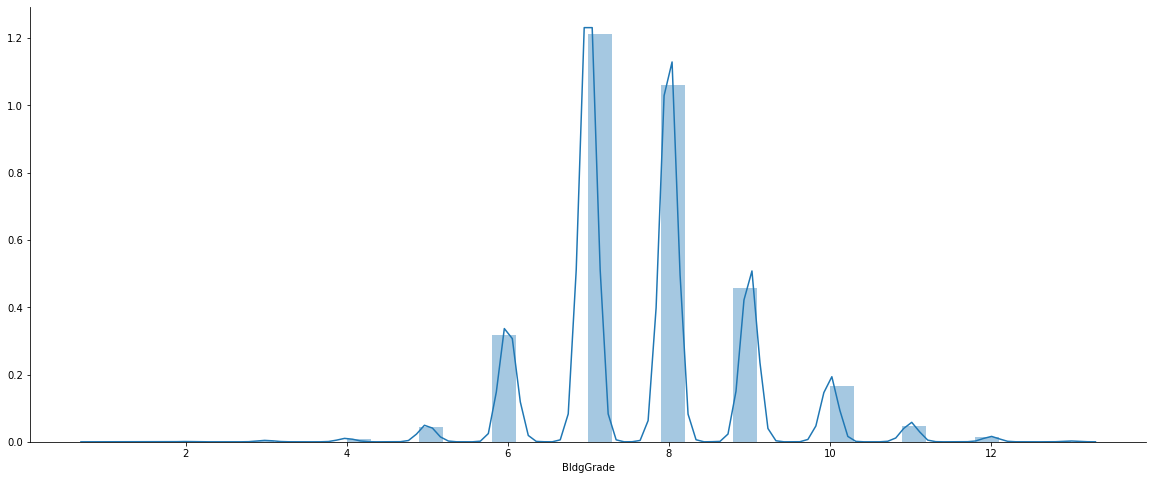

In [33]:
fig, axs = plt.subplots(figsize=(20,8))
sns.despine()

sns.distplot(groomed_df['BldgGrade'], bins=40)
;

''

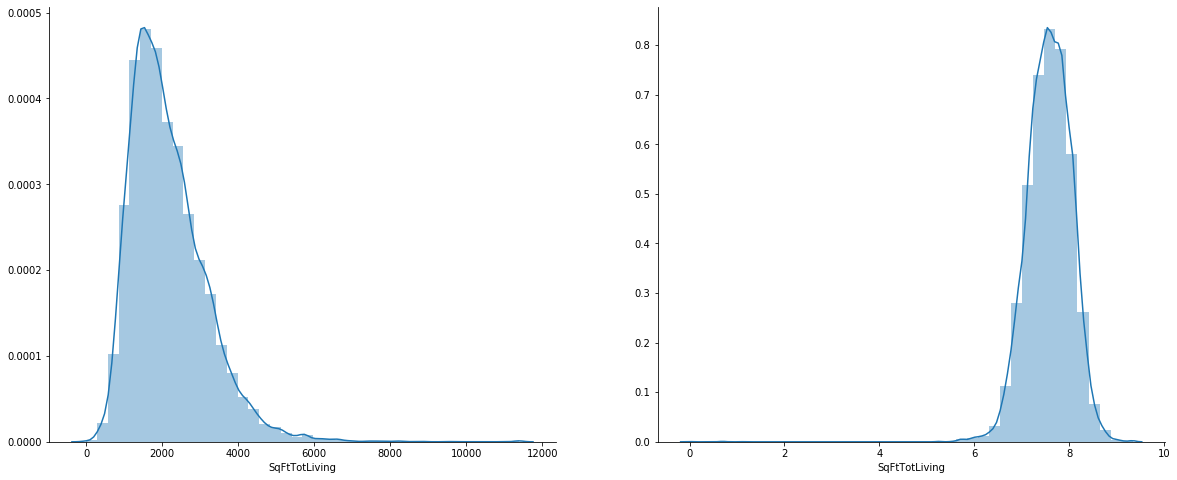

In [34]:
fig, axs = plt.subplots(1,2, figsize=(20,8))
sns.despine()

sns.distplot(groomed_df['SqFtTotLiving'], bins=40, ax=axs[0])
sns.distplot(np.log(groomed_df['SqFtTotLiving']), bins=40, ax=axs[1])
;

In [35]:
s = groomed_df['Area']
t = np.log(s).diff()
t.iat[0] = np.log(s.iat[0])
res = np.exp(t.cumsum())

''

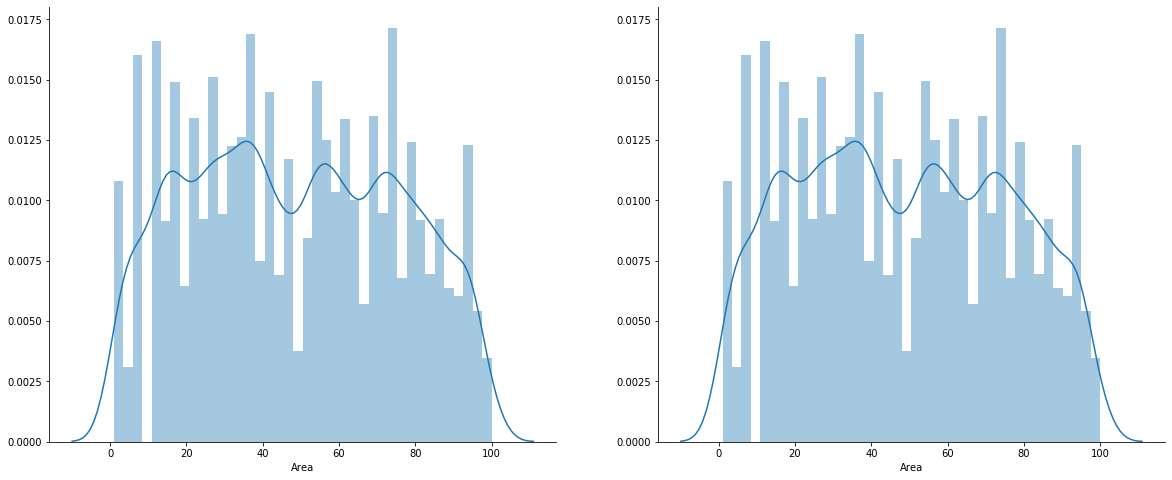

In [36]:
fig, axs = plt.subplots(1,2, figsize=(20,8))
sns.despine()
#  –log(1–u).
sns.distplot(groomed_df['Area'], bins=40, ax=axs[0])
sns.distplot(res, bins=40, ax=axs[1])
;